In [1]:
from src.model_utils import unpickle_sk_model
from src.constants import MODEL_DIR

ada_model = unpickle_sk_model(MODEL_DIR / "ada_amount_model.pkl")
rf_model = unpickle_sk_model(MODEL_DIR / "rf_amount_model.pkl")
gb_model = unpickle_sk_model(MODEL_DIR / "gb_amount_model.pkl")
pglm_model = unpickle_sk_model(MODEL_DIR / "pglm_amount_model.pkl")
nn_model = unpickle_sk_model(MODEL_DIR / "nn_amount_model.pkl")

In [2]:
from src.utils import load_dataframe
from src.constants import DATA_DIR

df = load_dataframe(DATA_DIR / "data_cleaned_PersonalProperty_encoded.csv")
df.head()

Data loaded successfully.


,student_id,name,class,gpa,is_greek,is_on_campus,distance_to_campus,is_female,is_sprinklered,claim_id,amount,risk_tier,holdout,Business,Humanities,Other,Science
0,1,"Saiz, Leslie",3,1.203913,0,0,0.000000,0.0,1,0,0.0,2,0,0,1,0,0
1,2,"Reddy, Dawna",3,0.609616,0,0,0.000000,1.0,1,0,0.0,2,0,0,0,0,1
2,3,"Rivera, Johnna",3,3.073385,0,1,0.223942,1.0,0,0,0.0,2,0,1,0,0,0
3,4,"al-Jamil, Umaira",4,3.224736,0,0,0.000000,0.0,0,0,0.0,3,0,1,0,0,0
4,5,"el-Mohammed, Qutb",2,2.687851,0,0,0.000000,1.0,0,0,0.0,1,0,1,0,0,0


In [3]:
# Separate the data into train and test sets based on the 'holdout' column
train_df = df[df["holdout"] == 0]
test_df = df[df["holdout"] == 1]

# Drop the 'holdout' column from the train and test sets
train_df = train_df.drop(
    columns=["holdout", "student_id", "name", "claim_id", "is_female"]
)
test_df = test_df.drop(
    columns=["holdout", "student_id", "name", "claim_id", "is_female"]
)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (8070, 12)
Test set shape: (1981, 12)


In [4]:
X_train = train_df.drop(columns=["risk_tier", "amount"]).to_numpy()
y_train_risk_tier = train_df[["risk_tier"]].to_numpy().reshape(-1, 1)
y_train_amount = train_df[["amount"]].to_numpy().reshape(-1, 1)

X_test = test_df.drop(columns=["risk_tier", "amount"]).to_numpy()
y_test_risk_tier = test_df[["risk_tier"]].to_numpy().reshape(-1, 1)
y_test_amount = test_df[["amount"]].to_numpy().reshape(-1, 1)

In [5]:
from sklearn.ensemble import StackingRegressor

model_ensemble = StackingRegressor(
    estimators=[
        ("ada", ada_model),
        ("rf", rf_model),
        ("gb", gb_model),
        ("pglm", pglm_model),
        ("nn", nn_model),
    ],
)

model_ensemble.fit(X_train, y_train_amount.ravel())

y_pred = model_ensemble.predict(X_test).reshape(-1, 1)

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np

train_rmse_amount = np.sqrt(
    mean_squared_error(y_train_amount, model_ensemble.predict(X_train))
)
test_rmse_amount = np.sqrt(mean_squared_error(y_test_amount, y_pred))

print(f"Train Mean Squared Error (Amount): {train_rmse_amount}")
print(f"Test Mean Squared Error (Amount): {test_rmse_amount}")

Train Mean Squared Error (Amount): 403.37384602333464
Test Mean Squared Error (Amount): 352.91435123796816


In [16]:
model_ensemble.named_estimators_

{'ada': AdaBoostRegressor(n_estimators=100, random_state=42),
 'rf': RandomForestRegressor(random_state=42),
 'gb': GradientBoostingRegressor(random_state=42),
 'pglm': PoissonRegressor(),
 'nn': MLPRegressor(early_stopping=True, hidden_layer_sizes=(64, 16), max_iter=1500,
              n_iter_no_change=15, random_state=42)}

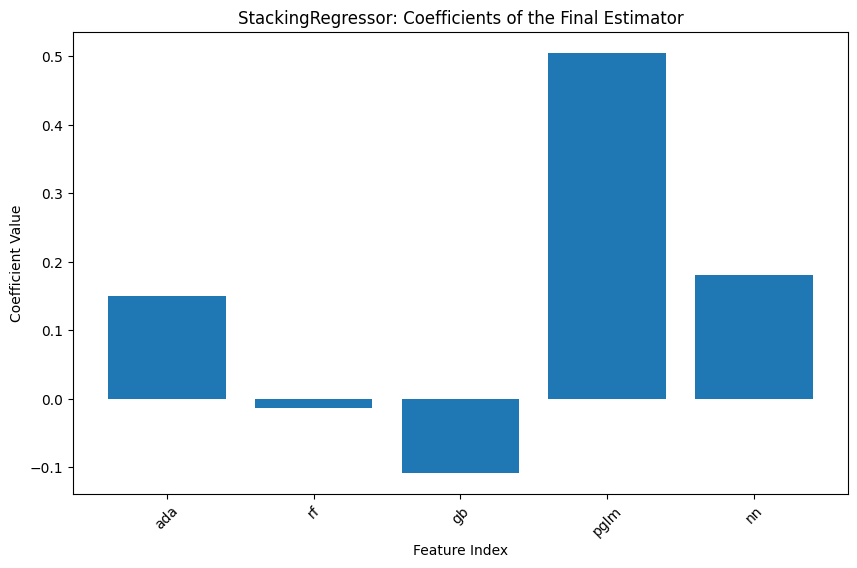

In [23]:
import matplotlib.pyplot as plt
from src.constants import IMG_DIR

# Extract coefficients from the final estimator
coefficients = model_ensemble.final_estimator_.coef_
model_labels = [name for (name, _) in model_ensemble.named_estimators_.items()]

plt.figure(figsize=(10, 6))
plt.bar(range(len(coefficients)), coefficients)
plt.xlabel("Feature Index")
plt.xticks(range(len(coefficients)), model_labels, rotation=45)
plt.ylabel("Coefficient Value")
plt.title("StackingRegressor: Coefficients of the Final Estimator")
plt.savefig(IMG_DIR / "ensemble" / "stacking_reg_coef.png")
plt.show()